<a href="https://colab.research.google.com/github/Ethan0625/NLP_mini_project/blob/main/01.Transformer_Chatbot/01_Transformer_Chatbot.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 한국어 데이터로 챗봇 만들기
# Trnsformer_Chatbot
***
## 프로젝트 요약
- 해당 프로젝트는 Transformer를 기반으로 한 Single turn 형태의 챗봇을 구현한 프로젝트입니다.    
- 영어 데이터셋과 한국어 데이터셋의 차이를 이해하고, 전처리과정에서 한글데이터는 어떤 특징을 갖는지 학습며 챗봇 모델의 기본구조를 이해하는데 목표를 두었습니다.  

## Dataset
- [송영숙님의 챗봇 데이터](https://github.com/songys/Chatbot_data)를 사용하였습니다.  
- 문답 페어 11,823개를 활용하였습니다.
***

### [Step 1] 데이터 불러오기

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


해당 프로젝트는 구글 코랩에서 작업하여 구글드라이브에서 데이터를 관리하였습니다.  
구글드라이브에서 데이터를 불러오는 [Jake님의 블로그](http://growthj.link/python-%EA%B5%AC%EA%B8%80-colab%EC%9C%BC%EB%A1%9C-pd-read-csv-%ED%99%9C%EC%9A%A9%ED%95%98%EB%8A%94-%EB%B0%A9%EB%B2%95/)를 참조하였습니다.

In [ ]:
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from collections import Counter
import os
import re

In [ ]:
# 데이터 가져오기
# chat_filepath =  '/content/drive/MyDrive/aiffel/data/songys_chatbot/Chatbot_data/ChatbotData .csv'
chat_filepath = '/aiffel/aiffel/transformer_chatbot/data/ChatbotData .csv'
chat_data = pd.read_csv(chat_filepath, sep=',')
chat_data.head()

,Q,A,label
0,12시 땡!,하루가 또 가네요.,0
1,1지망 학교 떨어졌어,위로해 드립니다.,0
2,3박4일 놀러가고 싶다,여행은 언제나 좋죠.,0
3,3박4일 정도 놀러가고 싶다,여행은 언제나 좋죠.,0
4,PPL 심하네,눈살이 찌푸려지죠.,0


해당 데이터는 질의, 답변, 감정분류(label)의 칼럼을 가지고 있습니다.  
간단한 챗봇모델을 만드는 것이 목표이기때문에 감정분류는 학습데이터에서 제외할 것입니다.
***

### [Step 2] 데이터 전처리하기
- 학습에 사용할 데이터는 한국어 데이터입니다.  
- 기본적인 전처리(특수문자 제거, 중복 단어 제거, 띄어쓰기 조절 등) 진행 후 문장을 토큰화하고 이를 정수화 하여 학습데이터로 사용할 예정입니다.
- 한국어 데이터의 경우 영어 데이터와는 다르게 띄어쓰기로 단어가 분류되지 않습니다. 

#### 1) 데이터 전처리
 학습에 사용할 데이터는 어느정도 정제된 데이터이므로 간단한 전처리 과정을 거칩니다.  
 전처리 과정에서는 아래의 과정을 거치게됩니다.  
 

> (1) 단어와 구두점(punctuation) 사이의 거리를 만듭니다.  
> (2) 한글, 영어, 숫자, 문장의 의미를 해치지 않는 특수문자를 제외한 모든 문자를 공백으로 대체합니다.  

In [ ]:
def preprocess_sentence(sentence):
    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
    sentence = re.sub(r'[" "]+', " ", sentence)
    sentence = re.sub(r"[^ㄱ-ㅎㅏ-ㅣ가-힣a-zA-Z0-9?.!,]", " ", sentence)
    sentence = sentence.strip()
    return sentence

In [ ]:
clean_Q=[]
for s in chat_data['Q']:
    clean_Q.append(preprocess_sentence(s))
clean_Q[:5], len(clean_Q)

(['12시 땡 !', '1지망 학교 떨어졌어', '3박4일 놀러가고 싶다', '3박4일 정도 놀러가고 싶다', 'PPL 심하네'],
 11823)

In [ ]:
clean_A=[]
for s in chat_data['A']:
    clean_A.append(preprocess_sentence(s))
clean_A[:5], len(clean_A)

(['하루가 또 가네요 .', '위로해 드립니다 .', '여행은 언제나 좋죠 .', '여행은 언제나 좋죠 .', '눈살이 찌푸려지죠 .'],
 11823)

In [ ]:
print('전체 샘플 수(질문) :', len(clean_Q))
print('전체 샘플 수(답변) :', len(clean_A))
print('전처리 후의 50번째 질문 샘플: {}'.format(clean_Q[49]))
print('전처리 후의 50번째 답변 샘플: {}'.format(clean_A[49]))

전체 샘플 수(질문) : 11823
전체 샘플 수(답변) : 11823
전처리 후의 50번째 질문 샘플: 감 말랭이 먹고 싶다 .
전처리 후의 50번째 답변 샘플: 맛있게 드세요 .


#### 2) 한국어 데이터와 영어 데이터의 차이
일반적으로 자연어처리는 텍스트를 '토큰 단위'로 나누어서 진행하게 됩니다.  
단순하게 '토큰'을 만들어내는 방법은 '띄어쓰기'가 있습니다.  
아래와 같이 'I am a student'라는 영어문장과 '나는 학생입니다'라는 한국어 문장이 있습니다.  

In [ ]:
eng_sen = 'I am a student'
kor_sen = '나는 학생입니다'

띄어쓰기로 토큰을 만들어 정리하면 아래와 같습니다.



In [ ]:
eng_token = eng_sen.split()
kor_token = kor_sen.split()
print('엉어 토큰 :',eng_token)
print('한국어 토큰 :',kor_token)

엉어 토큰 : ['I', 'am', 'a', 'student']
한국어 토큰 : ['나는', '학생입니다']


영어의 경우는 단순히 띄어쓰기로도 어느정도 명확하게 분류가 되지만, 한국어의 경우는 그렇지 않습니다.  
위에서 확인하였듯이 '나는 학생입니다'라는 문장은 '나', '는', '학생', '입니다'로 나뉘어져야 좀 더 명확하게 분류된다는 것을 알 수 있습니다.    
이러한 한국어의 특성때문에 한국어로 자연어처리를 하는 경우에는 보통 형태소 분석을 사용합니다.  

#### 3) 형태소 분석
형태소란 언어에 있어서 '최소 의미 단위'를 말합니다.  
일반적으로 자연어처리에서 형태소 분석이라함은 형태소를 분석하는 것이 아니라 문장을 형태소로 분석한다는 의미입니다.  
형태소 분석은 보통 상용되고있는 형태소 분석기를 활용하여 진행합니다.  
형태소 분석기는 'khaiii', 'Hannanum', 'KOMORAN', 'OKT', 'mecab' 등과 같은 여러가지 형태소 분석기가 있습니다.  
해당 프로젝트에서는 영어 데이터를 토큰화하는 데 사용하는 'SubwordTextEncoder'와 'mecab'을 사용하여 비교해볼 예정입니다.

##### 3-1) SubwordTextEncoder

In [ ]:
sub_tokenizer = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(clean_Q + clean_A, target_vocab_size=2**13)

한국어 데이터셋을 기반으로 단어사전을 만들어 주었기때문에 시작, 종료 토큰이 존재하지 않습니다.  
따라서 별개로 정수를 부여해주어야 합니다.

In [ ]:
# 시작 토큰과 종료 토큰에 고유한 정수를 부여합니다.
sub_START_TOKEN, sub_END_TOKEN = [sub_tokenizer.vocab_size], [sub_tokenizer.vocab_size + 1]
print('sub_START_TOKEN의 번호 :' ,[sub_tokenizer.vocab_size])
print('sub_END_TOKEN의 번호 :' ,[sub_tokenizer.vocab_size + 1])

sub_START_TOKEN의 번호 : [8172]
sub_END_TOKEN의 번호 : [8173]


총 단어사전의 크기는 시작, 종료 토큰을 추가해서 총 갯수에 +2를 해줍니다.

In [ ]:
sub_VOCAB_SIZE = sub_tokenizer.vocab_size + 2

길이가 너무 긴 경우에는 학습이 어려울 수 있으니 최대길이를 정해 학습에 용이하도록 수정해줍니다.

In [ ]:
def below_threshold_len(max_len, nested_list):
    cnt = 0
    for s in nested_list:
        if(len(s.split()) <= max_len):
            cnt = cnt + 1
    print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))))

In [ ]:
MAX_LENGTH = 40

In [ ]:
# 정수 인코딩, 최대 길이를 초과하는 샘플 제거, 패딩
def sub_tokenize_and_filter(inputs, outputs):
    tokenized_inputs, tokenized_outputs = [], []
    
    for (sentence1, sentence2) in zip(inputs, outputs):
        # 정수 인코딩 과정에서 시작 토큰과 종료 토큰을 추가
        sentence1 = sub_START_TOKEN + sub_tokenizer.encode(sentence1) + sub_END_TOKEN
        sentence2 = sub_START_TOKEN + sub_tokenizer.encode(sentence2) + sub_END_TOKEN

        # 최대 길이 40이하인 경우에만 데이터셋으로 허용
        if len(sentence1) <= MAX_LENGTH and len(sentence2) <= MAX_LENGTH:
            tokenized_inputs.append(sentence1)
            tokenized_outputs.append(sentence2)

    # 최대 길이 40으로 모든 데이터셋을 패딩
    tokenized_inputs = tf.keras.preprocessing.sequence.pad_sequences(
        tokenized_inputs, maxlen=MAX_LENGTH, padding='post')
    tokenized_outputs = tf.keras.preprocessing.sequence.pad_sequences(
        tokenized_outputs, maxlen=MAX_LENGTH, padding='post')

    return tokenized_inputs, tokenized_outputs

In [ ]:
sub_clean_Q, sub_clean_A = sub_tokenize_and_filter(clean_Q, clean_A)
print('단어장의 크기 :',(sub_VOCAB_SIZE))
print('필터링 후의 질문 샘플 개수: {}'.format(len(sub_clean_Q)))
print('필터링 후의 답변 샘플 개수: {}'.format(len(sub_clean_A)))

단어장의 크기 : 8174
필터링 후의 질문 샘플 개수: 11823
필터링 후의 답변 샘플 개수: 11823


In [ ]:
sub_clean_Q[49]

array([8172, 3172,  307, 8151, 8074, 8089,   11,  129,   67,    1, 8173,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0], dtype=int32)

In [ ]:
sub_tokenizer.decode([i for i in sub_clean_Q[49]if i < sub_tokenizer.vocab_size])

'감 말랭이 먹고 싶다 .'

In [ ]:
# 교사강요 사용
BATCH_SIZE = 64
BUFFER_SIZE = 20000

# 디코더는 이전의 target을 다음의 input으로 사용합니다.
# 이에 따라 outputs에서는 START_TOKEN을 제거하겠습니다.
sub_dataset = tf.data.Dataset.from_tensor_slices((
    {
        'inputs': sub_clean_Q,
        'dec_inputs': sub_clean_A[:, :-1]
    },
    {
        'outputs': sub_clean_A[:, 1:]
    },
))

sub_dataset = sub_dataset.cache()
sub_dataset = sub_dataset.shuffle(BUFFER_SIZE)
sub_dataset = sub_dataset.batch(BATCH_SIZE)
sub_dataset = sub_dataset.prefetch(tf.data.experimental.AUTOTUNE)

여기까지 SubwordTextEncoder를 활용하여 학습 데이터셋을 구성하였습니다.  
이제 mecab을 활용하여 구성해 보겠습니다.  

##### 3-2) mecab
mecab의 경우 따로 설치를 진행해주어야 합니다.

In [ ]:
!git clone https://github.com/SOMJANG/Mecab-ko-for-Google-Colab.git
%cd Mecab-ko-for-Google-Colab
!bash install_mecab-ko_on_colab190912.sh

Cloning into 'Mecab-ko-for-Google-Colab'...
remote: Enumerating objects: 91, done.
remote: Counting objects: 100% (91/91), done.
remote: Compressing objects: 100% (85/85), done.
remote: Total 91 (delta 43), reused 22 (delta 6), pack-reused 0
Unpacking objects: 100% (91/91), done.
/aiffel/aiffel/transformer_chatbot/Mecab-ko-for-Google-Colab
install_mecab-ko_on_colab190912.sh: line 4: cd: /content: No such file or directory
Installing konlpy.....
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.
Done
Installing mecab-0.996-ko-0.9.2.tar.gz.....
from https://bitbucket.org/eunjeon/mecab-ko/downloads/mecab-0.996-ko-0.9.2.tar.gz
--2021-08-18 23:53:55--  https://bitbucket.org/eunjeon/mecab-ko/downloads/mecab-0.996-ko-0.9.2.tar.gz
Resolving bitbucket.org (bitbucket.org)... 104.192.141.1, 2406:da00:ff00::22c3:9b0a, 2406:da00:ff00::34cc:ea4a, ...
Connecting to bitbucket.org (bitbucket.org)|104.192.141.1|:443... connected.
HTTP request sent, awa

In [ ]:
from konlpy.tag import Mecab
mecab=Mecab()

In [ ]:
# 정수 인코딩을 실제로 진행하기 위한 함수
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence]
    
# Q,A 칼럼에서 한문장씩 가져와 정수 인코딩 함수를 적용하여 return하는 함수
def vectorize(corpus, word_to_index):
    data = []
    for sen in corpus:
        sen = get_encoded_sentence(sen, word_to_index)
        data.append(sen)
    return data


# 정수 인코딩, 최대 길이를 초과하는 샘플 제거, 패딩
def mec_tokenize_and_filter(inputs, outputs):
    tokenized_inputs, tokenized_outputs = [], []

    for (sentence1, sentence2) in zip(inputs, outputs):
        # 정수 인코딩 과정 전 시작 토큰과 종료 토큰을 추가
        sentence1 = ['<BOS>'] + mecab.morphs(sentence1) + ['<EOS>']
        sentence2 = ['<BOS>'] + mecab.morphs(sentence2) + ['<EOS>']

        # 최대 길이 40이하인 경우에만 데이터셋으로 허용       
        if len(sentence1) <= 42 and len(sentence2) <= 42:
            tokenized_inputs.append(sentence1)
            tokenized_outputs.append(sentence2)

    print('최대길이 조절 후 input > ',len(tokenized_inputs))
    print('최대길이 조절 후 output > ', len(tokenized_outputs))

    total = tokenized_inputs + tokenized_outputs
    words = np.concatenate(total).tolist()
    counter = Counter(words)
    counter = counter.most_common(30000-2)
    vocab = ['<PAD>','<UNK>']+[key for key,_ in counter]
    word_to_index = {word:index for index, word in enumerate(vocab)}
    index_to_word = {index:word for word, index in word_to_index.items()}

    tokenized_inputs = vectorize(tokenized_inputs,word_to_index)
    tokenized_outputs = vectorize(tokenized_outputs,word_to_index)


    # 최대 길이 40으로 모든 데이터셋을 패딩
    tokenized_inputs = tf.keras.preprocessing.sequence.pad_sequences(
        tokenized_inputs, maxlen=MAX_LENGTH, padding='post')
    tokenized_outputs = tf.keras.preprocessing.sequence.pad_sequences(
        tokenized_outputs, maxlen=MAX_LENGTH, padding='post')
    
    return tokenized_inputs, tokenized_outputs, word_to_index, index_to_word

In [ ]:
mec_Q, mec_A, word_to_index, index_to_word = mec_tokenize_and_filter(clean_Q,clean_A)

최대길이 조절 후 input >  11823
최대길이 조절 후 output >  11823


In [ ]:
mec_Q[:5]

array([[   2, 2339,  174, 3338,   85,    3,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0],
       [   2,  282, 3339,  532,  996,   11,    3,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0],
       [   2,  299, 2077,  533,   60,  209,  234,   10,   12,   38,   30,
           3,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0],
       [   2,  299, 2077,  533,   60,  444,  209,  234,   10,   12,   38,
          30,    3,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,  

In [ ]:
mec_A[:5]

array([[   2,  247,   10,  146,   10,   36,    4,    3,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0],
       [   2,  521,   15, 1497,    4,    3,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0],
       [   2,  236,   18,  701,   13,   34,    4,    3,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0],
       [   2,  236,   18,  701,   13,   34,    4,    3,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,  

In [ ]:
mec_VOCAB_SIZE = len(word_to_index)
print('mecab활용 Vocab_size :',len(word_to_index))
print('mecab활용 Q_corpus :',len(mec_Q))
print('mecab활용 A_corpus :',len(mec_A))

mecab활용 Vocab_size : 6840
mecab활용 Q_corpus : 11823
mecab활용 A_corpus : 11823


In [ ]:
# 교사강요 사용
BATCH_SIZE = 64
BUFFER_SIZE = 20000

# 디코더는 이전의 target을 다음의 input으로 사용합니다.
# 이에 따라 outputs에서는 START_TOKEN을 제거하겠습니다.
mec_dataset = tf.data.Dataset.from_tensor_slices((
    {
        'inputs': mec_Q,
        'dec_inputs': mec_A[:, :-1]
    },
    {
        'outputs': mec_A[:, 1:]
    },
))

mec_dataset = mec_dataset.cache()
mec_dataset = mec_dataset.shuffle(BUFFER_SIZE)
mec_dataset = mec_dataset.batch(BATCH_SIZE)
mec_dataset = mec_dataset.prefetch(tf.data.experimental.AUTOTUNE)

***
### [Step 3] 모델 구성하기
- 학습에 활용되는 모델은 트랜스포머로 아래의 함수들은 프랜스포머를 구현하기 위한 함수들입니다.

In [ ]:
# 포지셔널 인코딩 레이어
class PositionalEncoding(tf.keras.layers.Layer):

    def __init__(self, position, d_model):
        super(PositionalEncoding, self).__init__()
        self.pos_encoding = self.positional_encoding(position, d_model)

    def get_angles(self, position, i, d_model):
        angles = 1 / tf.pow(10000, (2 * (i // 2)) / tf.cast(d_model, tf.float32))
        return position * angles

    def positional_encoding(self, position, d_model):
        angle_rads = self.get_angles(
            position=tf.range(position, dtype=tf.float32)[:, tf.newaxis],
            i=tf.range(d_model, dtype=tf.float32)[tf.newaxis, :],
            d_model=d_model)
        # 배열의 짝수 인덱스에는 sin 함수 적용
        sines = tf.math.sin(angle_rads[:, 0::2])
        # 배열의 홀수 인덱스에는 cosine 함수 적용
        cosines = tf.math.cos(angle_rads[:, 1::2])

        pos_encoding = tf.concat([sines, cosines], axis=-1)
        pos_encoding = pos_encoding[tf.newaxis, ...]
        return tf.cast(pos_encoding, tf.float32)

    def call(self, inputs):
        return inputs + self.pos_encoding[:, :tf.shape(inputs)[1], :]

In [ ]:
# 스케일드 닷 프로덕트 어텐션 함수
def scaled_dot_product_attention(query, key, value, mask):
    """어텐션 가중치를 계산. """
    matmul_qk = tf.matmul(query, key, transpose_b=True)

    # scale matmul_qk
    depth = tf.cast(tf.shape(key)[-1], tf.float32)
    logits = matmul_qk / tf.math.sqrt(depth)

    # add the mask to zero out padding tokens
    if mask is not None:
        logits += (mask * -1e9)

    # softmax is normalized on the last axis (seq_len_k)
    attention_weights = tf.nn.softmax(logits, axis=-1)

    output = tf.matmul(attention_weights, value)

    return output

In [ ]:
class MultiHeadAttention(tf.keras.layers.Layer):

    def __init__(self, d_model, num_heads, name="multi_head_attention"):
        super(MultiHeadAttention, self).__init__(name=name)
        self.num_heads = num_heads
        self.d_model = d_model

        assert d_model % self.num_heads == 0

        self.depth = d_model // self.num_heads

        self.query_dense = tf.keras.layers.Dense(units=d_model)
        self.key_dense = tf.keras.layers.Dense(units=d_model)
        self.value_dense = tf.keras.layers.Dense(units=d_model)

        self.dense = tf.keras.layers.Dense(units=d_model)

    def split_heads(self, inputs, batch_size):
        inputs = tf.reshape(
            inputs, shape=(batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(inputs, perm=[0, 2, 1, 3])

    def call(self, inputs):
        query, key, value, mask = inputs['query'], inputs['key'], inputs[
            'value'], inputs['mask']
        batch_size = tf.shape(query)[0]

        # linear layers
        query = self.query_dense(query)
        key = self.key_dense(key)
        value = self.value_dense(value)

        # 병렬 연산을 위한 머리를 여러 개 만듭니다.
        query = self.split_heads(query, batch_size)
        key = self.split_heads(key, batch_size)
        value = self.split_heads(value, batch_size)

        # 스케일드 닷 프로덕트 어텐션 함수
        scaled_attention = scaled_dot_product_attention(query, key, value, mask)

        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])

        # 어텐션 연산 후에 각 결과를 다시 연결(concatenate)합니다.
        concat_attention = tf.reshape(scaled_attention,
                                      (batch_size, -1, self.d_model))

        # final linear layer
        outputs = self.dense(concat_attention)

        return outputs

In [ ]:
def create_padding_mask(x):
    mask = tf.cast(tf.math.equal(x, 0), tf.float32)
    # (batch_size, 1, 1, sequence length)
    return mask[:, tf.newaxis, tf.newaxis, :]

In [ ]:
def create_look_ahead_mask(x):
    seq_len = tf.shape(x)[1]
    look_ahead_mask = 1 - tf.linalg.band_part(tf.ones((seq_len, seq_len)), -1, 0)
    padding_mask = create_padding_mask(x)
    return tf.maximum(look_ahead_mask, padding_mask)

In [ ]:
# 인코더 하나의 레이어를 함수로 구현.
# 이 하나의 레이어 안에는 두 개의 서브 레이어가 존재합니다.
def encoder_layer(units, d_model, num_heads, dropout, name="encoder_layer"):
    inputs = tf.keras.Input(shape=(None, d_model), name="inputs")

    # 패딩 마스크 사용
    padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

    # 첫 번째 서브 레이어 : 멀티 헤드 어텐션 수행 (셀프 어텐션)
    attention = MultiHeadAttention(
        d_model, num_heads, name="attention")({
          'query': inputs,
          'key': inputs,
          'value': inputs,
          'mask': padding_mask
        })

    # 어텐션의 결과는 Dropout과 Layer Normalization이라는 훈련을 돕는 테크닉을 수행
    attention = tf.keras.layers.Dropout(rate=dropout)(attention)
    attention = tf.keras.layers.LayerNormalization(epsilon=1e-6)(inputs + attention)

    # 두 번째 서브 레이어 : 2개의 완전연결층
    outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention)
    outputs = tf.keras.layers.Dense(units=d_model)(outputs)

    # 완전연결층의 결과는 Dropout과 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
    outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
    outputs = tf.keras.layers.LayerNormalization(epsilon=1e-6)(attention + outputs)

    return tf.keras.Model(
        inputs=[inputs, padding_mask], outputs=outputs, name=name)

In [ ]:
def encoder(vocab_size,
            num_layers,
            units,
            d_model,
            num_heads,
            dropout,
            name="encoder"):
    inputs = tf.keras.Input(shape=(None,), name="inputs")

    # 패딩 마스크 사용
    padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

    # 임베딩 레이어
    embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
    embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))

    # 포지셔널 인코딩
    embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)
    outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

    # num_layers만큼 쌓아올린 인코더의 층.
    for i in range(num_layers):
        outputs = encoder_layer(
            units=units,
            d_model=d_model,
            num_heads=num_heads,
            dropout=dropout,
            name="encoder_layer_{}".format(i),
        )([outputs, padding_mask])

    return tf.keras.Model(inputs=[inputs, padding_mask], outputs=outputs, name=name)

In [ ]:
# 디코더 하나의 레이어를 함수로 구현.
# 이 하나의 레이어 안에는 세 개의 서브 레이어가 존재합니다.
def decoder_layer(units, d_model, num_heads, dropout, name="decoder_layer"):
    inputs = tf.keras.Input(shape=(None, d_model), name="inputs")
    enc_outputs = tf.keras.Input(shape=(None, d_model), name="encoder_outputs")
    look_ahead_mask = tf.keras.Input(shape=(1, None, None), name="look_ahead_mask")
    padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')

    # 첫 번째 서브 레이어 : 멀티 헤드 어텐션 수행 (셀프 어텐션)
    attention1 = MultiHeadAttention(
        d_model, num_heads, name="attention_1")(inputs={
            'query': inputs,
            'key': inputs,
            'value': inputs,
            'mask': look_ahead_mask
        })

    # 멀티 헤드 어텐션의 결과는 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
    attention1 = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention1 + inputs)

    # 두 번째 서브 레이어 : 마스크드 멀티 헤드 어텐션 수행 (인코더-디코더 어텐션)
    attention2 = MultiHeadAttention(
        d_model, num_heads, name="attention_2")(inputs={
            'query': attention1,
            'key': enc_outputs,
            'value': enc_outputs,
            'mask': padding_mask
        })

    # 마스크드 멀티 헤드 어텐션의 결과는
    # Dropout과 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
    attention2 = tf.keras.layers.Dropout(rate=dropout)(attention2)
    attention2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)(attention2 + attention1)

    # 세 번째 서브 레이어 : 2개의 완전연결층
    outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention2)
    outputs = tf.keras.layers.Dense(units=d_model)(outputs)

    # 완전연결층의 결과는 Dropout과 LayerNormalization 수행
    outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
    outputs = tf.keras.layers.LayerNormalization(epsilon=1e-6)(outputs + attention2)

    return tf.keras.Model(
        inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
        outputs=outputs,name=name)

In [ ]:
def decoder(vocab_size,
            num_layers,
            units,
            d_model,
            num_heads,
            dropout,
            name='decoder'):
    inputs = tf.keras.Input(shape=(None,), name='inputs')
    enc_outputs = tf.keras.Input(shape=(None, d_model), name='encoder_outputs')
    look_ahead_mask = tf.keras.Input(shape=(1, None, None), name='look_ahead_mask')

    # 패딩 마스크
    padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')

    # 임베딩 레이어
    embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
    embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))

    # 포지셔널 인코딩
    embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)

    # Dropout이라는 훈련을 돕는 테크닉을 수행
    outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

    for i in range(num_layers):
        outputs = decoder_layer(
            units=units,
            d_model=d_model,
            num_heads=num_heads,
            dropout=dropout,
            name='decoder_layer_{}'.format(i),
        )(inputs=[outputs, enc_outputs, look_ahead_mask, padding_mask])

    return tf.keras.Model(
        inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
        outputs=outputs,name=name)

모델 구성에 필요한 함수들을 다 만들었으니 이제 모델을 구성하여 학습시켜보겠습니다.  
학습데이터를 토큰화하는데 2가지의 토크나이저를 사용하였으니 이에따라 모델을 나누어 학습을 진행하겠습니다.  
#### 1) SubwordTextEncoder 모델구성

In [ ]:
#모델 정의 및 학습하기
def sub_transformer(vocab_size,
                num_layers,
                units,
                d_model,
                num_heads,
                dropout,
                name="sub_transformer"):
    inputs = tf.keras.Input(shape=(None,), name="inputs")
    dec_inputs = tf.keras.Input(shape=(None,), name="dec_inputs")

    # 인코더에서 패딩을 위한 마스크
    enc_padding_mask = tf.keras.layers.Lambda(
        create_padding_mask, output_shape=(1, 1, None),
        name='enc_padding_mask')(inputs)

    # 디코더에서 미래의 토큰을 마스크 하기 위해서 사용합니다.
    # 내부적으로 패딩 마스크도 포함되어져 있습니다.
    look_ahead_mask = tf.keras.layers.Lambda(
        create_look_ahead_mask,
        output_shape=(1, None, None),
        name='look_ahead_mask')(dec_inputs)

    # 두 번째 어텐션 블록에서 인코더의 벡터들을 마스킹
    # 디코더에서 패딩을 위한 마스크
    dec_padding_mask = tf.keras.layers.Lambda(
        create_padding_mask, output_shape=(1, 1, None),
        name='dec_padding_mask')(inputs)

    # 인코더
    enc_outputs = encoder(
        vocab_size=vocab_size,
        num_layers=num_layers,
        units=units,
        d_model=d_model,
        num_heads=num_heads,
        dropout=dropout,
    )(inputs=[inputs, enc_padding_mask])

    # 디코더
    dec_outputs = decoder(
        vocab_size=vocab_size,
        num_layers=num_layers,
        units=units,
        d_model=d_model,
        num_heads=num_heads,
        dropout=dropout,
    )(inputs=[dec_inputs, enc_outputs, look_ahead_mask, dec_padding_mask])

    # 완전연결층
    outputs = tf.keras.layers.Dense(units=vocab_size, name="outputs")(dec_outputs)

    return tf.keras.Model(inputs=[inputs, dec_inputs], outputs=outputs, name=name)

In [ ]:
#모델 생성
tf.keras.backend.clear_session()

# 하이퍼파라미터
NUM_LAYERS = 6 # 인코더와 디코더의 층의 개수
D_MODEL = 512 # 인코더와 디코더 내부의 입, 출력의 고정 차원
NUM_HEADS = 8 # 멀티 헤드 어텐션에서의 헤드 수 
UNITS = 512 # 피드 포워드 신경망의 은닉층의 크기
DROPOUT = 0.1 # 드롭아웃의 비율

sub_model = sub_transformer(
    vocab_size=sub_VOCAB_SIZE,
    num_layers=NUM_LAYERS,
    units=UNITS,
    d_model=D_MODEL,
    num_heads=NUM_HEADS,
    dropout=DROPOUT)

sub_model.summary()

Model: "sub_transformer"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inputs (InputLayer)             [(None, None)]       0                                            
__________________________________________________________________________________________________
dec_inputs (InputLayer)         [(None, None)]       0                                            
__________________________________________________________________________________________________
enc_padding_mask (Lambda)       (None, 1, 1, None)   0           inputs[0][0]                     
__________________________________________________________________________________________________
encoder (Functional)            (None, None, 512)    13652992    inputs[0][0]                     
                                                                 enc_padding_mask[0]

#### 2) Mecab 모델 구성

In [ ]:
#모델 정의 및 학습하기
def mec_transformer(vocab_size,
                num_layers,
                units,
                d_model,
                num_heads,
                dropout,
                name="mec_transformer"):
    inputs = tf.keras.Input(shape=(None,), name="inputs")
    dec_inputs = tf.keras.Input(shape=(None,), name="dec_inputs")

    # 인코더에서 패딩을 위한 마스크
    enc_padding_mask = tf.keras.layers.Lambda(
        create_padding_mask, output_shape=(1, 1, None),
        name='enc_padding_mask')(inputs)

    # 디코더에서 미래의 토큰을 마스크 하기 위해서 사용합니다.
    # 내부적으로 패딩 마스크도 포함되어져 있습니다.
    look_ahead_mask = tf.keras.layers.Lambda(
        create_look_ahead_mask,
        output_shape=(1, None, None),
        name='look_ahead_mask')(dec_inputs)

    # 두 번째 어텐션 블록에서 인코더의 벡터들을 마스킹
    # 디코더에서 패딩을 위한 마스크
    dec_padding_mask = tf.keras.layers.Lambda(
        create_padding_mask, output_shape=(1, 1, None),
        name='dec_padding_mask')(inputs)

    # 인코더
    enc_outputs = encoder(
        vocab_size=vocab_size,
        num_layers=num_layers,
        units=units,
        d_model=d_model,
        num_heads=num_heads,
        dropout=dropout,
    )(inputs=[inputs, enc_padding_mask])

    # 디코더
    dec_outputs = decoder(
        vocab_size=vocab_size,
        num_layers=num_layers,
        units=units,
        d_model=d_model,
        num_heads=num_heads,
        dropout=dropout,
    )(inputs=[dec_inputs, enc_outputs, look_ahead_mask, dec_padding_mask])

    # 완전연결층
    outputs = tf.keras.layers.Dense(units=vocab_size, name="outputs")(dec_outputs)

    return tf.keras.Model(inputs=[inputs, dec_inputs], outputs=outputs, name=name)

In [ ]:
#모델 생성
tf.keras.backend.clear_session()

# 하이퍼파라미터
NUM_LAYERS = 6 # 인코더와 디코더의 층의 개수
D_MODEL = 512 # 인코더와 디코더 내부의 입, 출력의 고정 차원
NUM_HEADS = 8 # 멀티 헤드 어텐션에서의 헤드 수 
UNITS = 512 # 피드 포워드 신경망의 은닉층의 크기
DROPOUT = 0.1 # 드롭아웃의 비율

mec_model = mec_transformer(
    vocab_size=mec_VOCAB_SIZE,
    num_layers=NUM_LAYERS,
    units=UNITS,
    d_model=D_MODEL,
    num_heads=NUM_HEADS,
    dropout=DROPOUT)

mec_model.summary()

Model: "mec_transformer"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inputs (InputLayer)             [(None, None)]       0                                            
__________________________________________________________________________________________________
dec_inputs (InputLayer)         [(None, None)]       0                                            
__________________________________________________________________________________________________
enc_padding_mask (Lambda)       (None, 1, 1, None)   0           inputs[0][0]                     
__________________________________________________________________________________________________
encoder (Functional)            (None, None, 512)    12969984    inputs[0][0]                     
                                                                 enc_padding_mask[0]

In [ ]:
#손실함수
def loss_function(y_true, y_pred):
    y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))

    loss = tf.keras.losses.SparseCategoricalCrossentropy(
        from_logits=True, reduction='none')(y_true, y_pred)

    mask = tf.cast(tf.not_equal(y_true, 0), tf.float32)
    loss = tf.multiply(loss, mask)

    return tf.reduce_mean(loss)

In [ ]:
#커스텀된 학습률
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):

    def __init__(self, d_model, warmup_steps=4000):
        super(CustomSchedule, self).__init__()

        self.d_model = d_model
        self.d_model = tf.cast(self.d_model, tf.float32)

        self.warmup_steps = warmup_steps

    def __call__(self, step):
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps**-1.5)

        return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

Text(0.5, 0, 'Train Step')

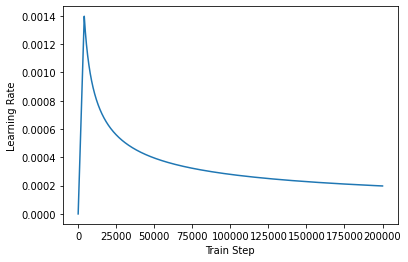

In [ ]:
#커스텀 학습률 스케줄링 계획 시각화
sample_learning_rate = CustomSchedule(d_model=128)

plt.plot(sample_learning_rate(tf.range(200000, dtype=tf.float32)))
plt.ylabel("Learning Rate")
plt.xlabel("Train Step")

In [ ]:
#모델 컴파일
learning_rate = CustomSchedule(D_MODEL)

optimizer = tf.keras.optimizers.Adam(
    learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

def accuracy(y_true, y_pred):
    y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
    return tf.keras.metrics.sparse_categorical_accuracy(y_true, y_pred)

sub_model.compile(optimizer=optimizer, loss=loss_function, metrics=[accuracy])

#### 3) 각 모델 훈련

In [ ]:
# 훈련하기
# 인퍼런스 과정을 반복할때 사용할 가중치를 따로 저장합니다.
# sub_checkpoint_path = "/content/drive/MyDrive/aiffel/data/songys_chatbot/Model_save/sub_cp.ckpt"
sub_checkpoint_path = "/aiffel/aiffel/transformer_chatbot/data/Model_save/sub_cp.ckpt"
sub_checkpoint_dir = os.path.dirname(sub_checkpoint_path)
# 모델의 가중치를 저장하는 콜백 만들기
sub_cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=sub_checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

EPOCHS = 50
sub_model.fit(sub_dataset, epochs=EPOCHS, callbacks=[sub_cp_callback])

Epoch 1/50
185/185 [==============================] - 108s 464ms/step - loss: 1.3488 - accuracy: 0.0263

Epoch 00001: saving model to /content/drive/MyDrive/aiffel/data/songys_chatbot/Model_save/sub_cp.ckpt
Epoch 2/50
185/185 [==============================] - 86s 464ms/step - loss: 1.0737 - accuracy: 0.0494

Epoch 00002: saving model to /content/drive/MyDrive/aiffel/data/songys_chatbot/Model_save/sub_cp.ckpt
Epoch 3/50
185/185 [==============================] - 86s 464ms/step - loss: 0.9861 - accuracy: 0.0506

Epoch 00003: saving model to /content/drive/MyDrive/aiffel/data/songys_chatbot/Model_save/sub_cp.ckpt
Epoch 4/50
185/185 [==============================] - 86s 464ms/step - loss: 0.9413 - accuracy: 0.0525

Epoch 00004: saving model to /content/drive/MyDrive/aiffel/data/songys_chatbot/Model_save/sub_cp.ckpt
Epoch 5/50
185/185 [==============================] - 86s 465ms/step - loss: 0.9088 - accuracy: 0.0544

Epoch 00005: saving model to /content/drive/MyDrive/aiffel/data/songys_

In [ ]:
#모델 컴파일
learning_rate = CustomSchedule(D_MODEL)

optimizer = tf.keras.optimizers.Adam(
    learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

def accuracy(y_true, y_pred):
    y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
    return tf.keras.metrics.sparse_categorical_accuracy(y_true, y_pred)

mec_model.compile(optimizer=optimizer, loss=loss_function, metrics=[accuracy])

In [ ]:
#훈련하기
# 인퍼런스 과정을 반복할때 사용할 가중치를 따로 저장합니다.
# mec_checkpoint_path = "/content/drive/MyDrive/aiffel/data/songys_chatbot/Model_save/mec_cp.ckpt"
mec_checkpoint_path = "/aiffel/aiffel/transformer_chatbot/data/Model_save/mec_cp.ckpt"
mec_checkpoint_dir = os.path.dirname(mec_checkpoint_path)
# 모델의 가중치를 저장하는 콜백 만들기
mec_cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=mec_checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)
EPOCHS = 50
mec_model.fit(mec_dataset, epochs=EPOCHS, callbacks=[mec_cp_callback])

Epoch 1/50
185/185 [==============================] - 85s 460ms/step - loss: 1.2403 - accuracy: 0.0544

Epoch 00001: saving model to /aiffel/aiffel/transformer_chatbot/data/Model_save/mec_cp.ckpt
Epoch 2/50
185/185 [==============================] - 86s 465ms/step - loss: 1.0644 - accuracy: 0.0697

Epoch 00002: saving model to /aiffel/aiffel/transformer_chatbot/data/Model_save/mec_cp.ckpt
Epoch 3/50
185/185 [==============================] - 86s 467ms/step - loss: 0.9282 - accuracy: 0.0871

Epoch 00003: saving model to /aiffel/aiffel/transformer_chatbot/data/Model_save/mec_cp.ckpt
Epoch 4/50
185/185 [==============================] - 87s 471ms/step - loss: 0.8360 - accuracy: 0.0968

Epoch 00004: saving model to /aiffel/aiffel/transformer_chatbot/data/Model_save/mec_cp.ckpt
Epoch 5/50
185/185 [==============================] - 87s 472ms/step - loss: 0.7662 - accuracy: 0.1048

Epoch 00005: saving model to /aiffel/aiffel/transformer_chatbot/data/Model_save/mec_cp.ckpt
Epoch 6/50
185/185 [

Epoch 43/50
185/185 [==============================] - 88s 474ms/step - loss: 0.0749 - accuracy: 0.2184

Epoch 00043: saving model to /aiffel/aiffel/transformer_chatbot/data/Model_save/mec_cp.ckpt
Epoch 44/50
185/185 [==============================] - 87s 472ms/step - loss: 0.0726 - accuracy: 0.2193

Epoch 00044: saving model to /aiffel/aiffel/transformer_chatbot/data/Model_save/mec_cp.ckpt
Epoch 45/50
185/185 [==============================] - 88s 475ms/step - loss: 0.0680 - accuracy: 0.2205

Epoch 00045: saving model to /aiffel/aiffel/transformer_chatbot/data/Model_save/mec_cp.ckpt
Epoch 46/50
185/185 [==============================] - 88s 474ms/step - loss: 0.0679 - accuracy: 0.2204

Epoch 00046: saving model to /aiffel/aiffel/transformer_chatbot/data/Model_save/mec_cp.ckpt
Epoch 47/50
185/185 [==============================] - 88s 474ms/step - loss: 0.0640 - accuracy: 0.2215

Epoch 00047: saving model to /aiffel/aiffel/transformer_chatbot/data/Model_save/mec_cp.ckpt
Epoch 48/50
185

***
### [Step 4] 모델 평가하기
- Step 1에서 선택한 전처리 방법을 고려하여 입력된 문장에 대해서 대답을 얻는 예측 함수를 만듭니다.  

#### 1) SubwordTextEncoder Inference

In [ ]:
sub_model.load_weights(sub_checkpoint_path)

In [ ]:
#챗봇 테스트하기
def sub_decoder_inference(sentence):
    sentence = preprocess_sentence(sentence)

    # 입력된 문장을 정수 인코딩 후, 시작 토큰과 종료 토큰을 앞뒤로 추가.
    # ex) Where have you been? → [[8331   86   30    5 1059    7 8332]]
    sentence = tf.expand_dims(
        sub_START_TOKEN + sub_tokenizer.encode(sentence) + sub_END_TOKEN, axis=0)

    # 디코더의 현재까지의 예측한 출력 시퀀스가 지속적으로 저장되는 변수.
    # 처음에는 예측한 내용이 없음으로 시작 토큰만 별도 저장. ex) 8331
    sub_output_sequence = tf.expand_dims(sub_START_TOKEN, 0)

    # 디코더의 인퍼런스 단계
    for i in range(MAX_LENGTH):
        # 디코더는 최대 MAX_LENGTH의 길이만큼 다음 단어 예측을 반복합니다.
        sub_predictions = sub_model(inputs=[sentence, sub_output_sequence], training=False)
        sub_predictions = sub_predictions[:, -1:, :]

        # 현재 예측한 단어의 정수
        sub_predicted_id = tf.cast(tf.argmax(sub_predictions, axis=-1), tf.int32)

        # 만약 현재 예측한 단어가 종료 토큰이라면 for문을 종료
        if tf.equal(sub_predicted_id, sub_END_TOKEN[0]):
            break

        # 예측한 단어들은 지속적으로 output_sequence에 추가됩니다.
        # 이 output_sequence는 다시 디코더의 입력이 됩니다.
        sub_output_sequence = tf.concat([sub_output_sequence, sub_predicted_id], axis=-1)

    return tf.squeeze(sub_output_sequence, axis=0)

In [ ]:
#챗봇의 대답을 얻는 함수
def sub_sentence_generation(sentence):
    # 입력 문장에 대해서 디코더를 동작 시켜 예측된 정수 시퀀스를 리턴받습니다.
    sub_prediction = sub_decoder_inference(sentence)

    # 정수 시퀀스를 다시 텍스트 시퀀스로 변환합니다.
    sub_predicted_sentence = sub_tokenizer.decode(
        [i for i in sub_prediction if i < sub_tokenizer.vocab_size])

    print('입력 : {}'.format(sentence))
    print('출력 : {}'.format(sub_predicted_sentence))

-모델 테스트

In [ ]:
sub_sentence_generation('잠이 오네')

입력 : 잠이 오네
출력 : 잠시 쉬었다 가세요 .


In [ ]:
sub_sentence_generation('배고프다')

입력 : 배고프다
출력 : 저도 밥 먹고 싶어요


#### 2) Mecab Inference

In [ ]:
mec_model.load_weights(mec_checkpoint_path)

In [ ]:
#챗봇 테스트하기
def mec_decoder_inference(sentence, word_to_index):
    sentence = preprocess_sentence(sentence)

    # 입력된 문장을 정수 인코딩 후, 시작 토큰과 종료 토큰을 앞뒤로 추가.
    # ex) Where have you been? → [[8331   86   30    5 1059    7 8332]]
    sentence = tf.expand_dims(
        [word_to_index['<BOS>']] + get_encoded_sentence(sentence, word_to_index) + [word_to_index['<EOS>']], axis=0)

    # 디코더의 현재까지의 예측한 출력 시퀀스가 지속적으로 저장되는 변수.
    # 처음에는 예측한 내용이 없음으로 시작 토큰만 별도 저장. ex) 8331
    mec_output_sequence = tf.expand_dims([word_to_index['<BOS>']], 0)

    # 디코더의 인퍼런스 단계
    for i in range(MAX_LENGTH):
        # 디코더는 최대 MAX_LENGTH의 길이만큼 다음 단어 예측을 반복합니다.
        mec_predictions = mec_model(inputs=[sentence, mec_output_sequence], training=False)
        mec_predictions = mec_predictions[:, -1:, :]

        # 현재 예측한 단어의 정수
        mec_predicted_id = tf.cast(tf.argmax(mec_predictions, axis=-1), tf.int32)

        # 만약 현재 예측한 단어가 종료 토큰이라면 for문을 종료
        if tf.equal(mec_predicted_id, word_to_index['<EOS>']):
            break

        # 예측한 단어들은 지속적으로 output_sequence에 추가됩니다.
        # 이 output_sequence는 다시 디코더의 입력이 됩니다.
        mec_output_sequence = tf.concat([mec_output_sequence, mec_predicted_id], axis=-1)

    return tf.squeeze(mec_output_sequence, axis=0)

In [ ]:
#챗봇의 대답을 얻는 함수
def mec_sentence_generation(sentence, word_to_index):
    # 입력 문장에 대해서 디코더를 동작 시켜 예측된 정수 시퀀스를 리턴받습니다.
    mec_prediction = mec_decoder_inference(sentence, word_to_index)

    # 정수 시퀀스를 다시 텍스트 시퀀스로 변환합니다.
    
    mec_predicted_sentence = [index_to_word[int(i)] for i in mec_prediction if i < len(word_to_index)]

    print('입력 : {}'.format(sentence))
    print('출력 : {}'.format(mec_predicted_sentence[1:]))

In [ ]:
mec_sentence_generation('잠이 오네', word_to_index)

입력 : 잠이 오네
출력 : ['잠', '이', '최고', '의', '보약', '이', '에요', '.', '노력', '해', '보', '세요', '.']


In [ ]:
mec_sentence_generation('배고프다',word_to_index)

입력 : 배고프다
출력 : ['시원', '하', '게', '씻', '고', '오', '세요', '.']


결과를 비교해보았을 때 SubwordTextEncoder보다 Mecab이 더 자연스러운 문장을 만들어내는 경우도 있으나, 반대의 경우도 있었습니다.  
SbwordTextEncoder의 경우 띄어쓰기를 기반으로 학습이 진행되기때문에 문장형성에도 이러한 부분이 반영됩니다.  
반면에 Mecab의 경우 형태소를 기반으로 학습이 진행되기 때문에 띄어쓰기를 따로 토큰으로 형성해야 합니다.  
추가적으로 inference과정에서 해당부분을 반영할 수 있는 함수를 구현해주어야 할 것으로 보입니다.  
해당 미니프로젝트는 이를 고려하지않고 SubwordTextEncoder와 Mecab을 단순 비교하는 과정을 거쳤기때문에  
성능부분에 크게 차이가 보이지는 않는 결과를 보인 것으로 판단됩니다.

***
### [Last Step] Reference
[송영숙님의 챗봇 데이터](https://github.com/songys/Chatbot_data)  
[Jake님의 블로그(구글드라이브)](http://growthj.link/python-%EA%B5%AC%EA%B8%80-colab%EC%9C%BC%EB%A1%9C-pd-read-csv-%ED%99%9C%EC%9A%A9%ED%95%98%EB%8A%94-%EB%B0%A9%EB%B2%95/)  
[형태소 분석에 관해서](https://m.blog.naver.com/PostView.naver?isHttpsRedirect=true&blogId=sw4r&logNo=221097202405)  
[형태소 분석기 비교(by ratsgo)](https://ratsgo.github.io/from%20frequency%20to%20semantics/2017/05/10/postag/)  
[형태소 분석기 비교(mecab 포함)](https://iostream.tistory.com/144)  
[PyTorch로 시작하는 딥 러닝 입문](https://wikidocs.net/64517)  
[seq2seq 및 교사강요](https://bkshin.tistory.com/entry/NLP-13-%EC%8B%9C%ED%80%80%EC%8A%A4%ED%88%AC%EC%8B%9C%ED%80%80%EC%8A%A4seq2seq?category=1097026)